In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import random
from sklearn.metrics import mean_absolute_error
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Leitura dados IBGE

In [3]:
ibge = pd.read_csv('ibge_populacao_2009_2019.csv', sep=';')
ibge.columns = ['ANO', 'GOIANIA', 'GOIAS']
ibge.head()

,ANO,GOIANIA,GOIAS
0,2009,1281975,5926300
1,2010,1301892,6004045
2,2011,1318148,6080588
3,2012,1333767,6154996
4,2013,1393575,6434048


In [4]:
ibge['MES'] = [pd.to_datetime(datetime.date(ano, 12, 31)) for ano in ibge.ANO]
ibge = ibge.sort_values(by=['MES'])
ibge = ibge.set_index('MES')
ibge.drop(columns='ANO', inplace=True)

In [5]:
#Os dados do Ibge são fornecidos por ano (censo ou estimativa), todavia
#  para a análise em conjunto com os dados do SIHSUS, os dados devem ser retradas mensalsamente
ibge_periodo = pd.DataFrame(columns=['GOIANIA', 'GOIAS'], index=pd.Index(pd.date_range(start='2009-01-01',\
                                                                        end='2019-12-31', freq='M', closed='right')))
ibge_periodo.drop(index = ibge.index, inplace=True)
ibge = ibge.append(ibge_periodo)

#Dados do IBGE para o ano de 2008 como o início para o ano de 2009
ibge = ibge.append(pd.DataFrame({'GOIANIA': 1265394, 'GOIAS': 5844996}, index=pd.Index([pd.to_datetime('2009-01-01')])))

ibge.index.name = 'MES'
ibge = ibge.sort_values(by='MES')

In [6]:
ibge['GOIAS'] = pd.to_numeric(ibge['GOIAS'], errors='coerce', downcast='integer')
ibge['GOIANIA'] = pd.to_numeric(ibge['GOIANIA'], errors='coerce', downcast='integer')

In [7]:
# Para o novo conjunto representando o mês, utilizou interpolação linear.
# Os pontos conhecidos são a população no início do ano e no final do ano, sendo
#    assim os novos pontos de alcance serão a evolução entre estas duas datas tomadas
#    mês a mês.
ibge = ibge.interpolate(limit_direction='both')
ibge = ibge.drop(index=pd.to_datetime('2009-01-01'))
ibge.index = ibge.index.to_period('M')

<AxesSubplot:title={'center':'Estimativa Populacional - Município de Goiânia'}, xlabel='Mês', ylabel='População'>

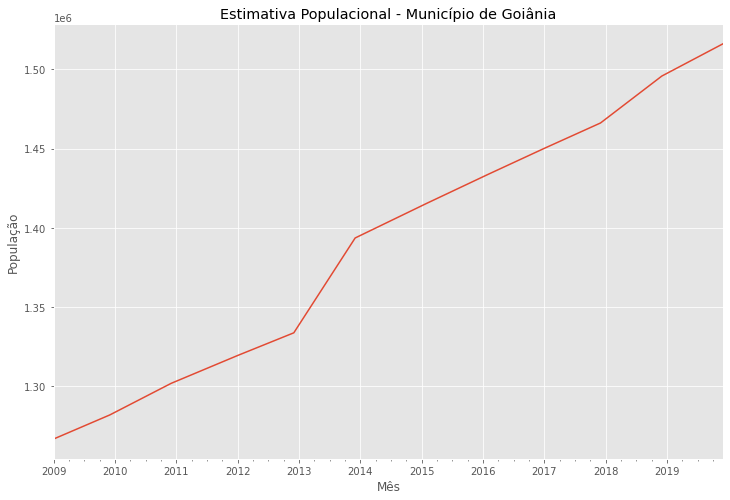

In [8]:
ibge['GOIANIA'].plot(figsize=(12,8),legend=False, xlabel='Mês',
                  ylabel='População', title = 'Estimativa Populacional - Município de Goiânia')

### Leitura dos dados do SIHSUS

In [9]:
aih_uti = pd.read_csv('sihsus_uti_goiania_total.csv', sep=';')
aih_uti.head()

,MES,0802010083 DIARIA DE UNIDADE DE TERAPIA INTENSIVA ADULTO (UTI II),0802010105 DIARIA DE UNIDADE DE TERAPIA INTENSIVA DE ADULTO (UTI I)
0,2007/Jun,51,-
1,2007/Ago,55,-
2,2007/Set,82,-
3,2007/Out,78,7
4,2007/Nov,394,21


In [10]:
# Os dados são extraídos por tipo de UTI, mas
#   neste estudo importa apenas o total para a UTI Adulto
aih_uti.columns = ['MES', 'UTI_II', 'UTI_I']

In [11]:
#Transforma o mês no formato string (ex. 2020/Abr) em datetime
aih_uti['ANO'] = [int(ano[0]) for ano in aih_uti['MES'].str.split('/')]
aih_uti['MES'] = [ano[1] for ano in aih_uti['MES'].str.split('/')]
mes_numerico = {'Jan': 1, 'Fev': 2, 'Mar': 3, 'Abr': 4,  'Mai': 5, 'Jun': 6,
                'Jul': 7, 'Ago': 8, 'Set': 9, 'Out': 10, 'Nov':11, 'Dez':12 }
aih_uti['MES'] = aih_uti['MES'].replace(mes_numerico)
aih_uti['MES'] = pd.to_datetime([datetime.date(row[1]['ANO'], row[1]['MES'] , 1) for row in aih_uti.iterrows()])
aih_uti.drop(columns=['ANO'], inplace=True)

In [12]:
aih_uti['UTI_II'] = pd.to_numeric(aih_uti['UTI_II'], errors='coerce').fillna(0)
aih_uti['UTI_I']  = pd.to_numeric(aih_uti['UTI_I'], errors='coerce').fillna(0)
aih_uti['DIARIAS_UTI'] = aih_uti['UTI_I'] + aih_uti['UTI_II']
aih_uti = aih_uti[['MES', 'DIARIAS_UTI']]

In [13]:
aih_uti = aih_uti.sort_values(by=['MES'])
aih_uti = aih_uti.set_index('MES')['2009-01-01': '2019-12-31']

In [14]:
aih_uti.index = aih_uti.index.to_period('M')

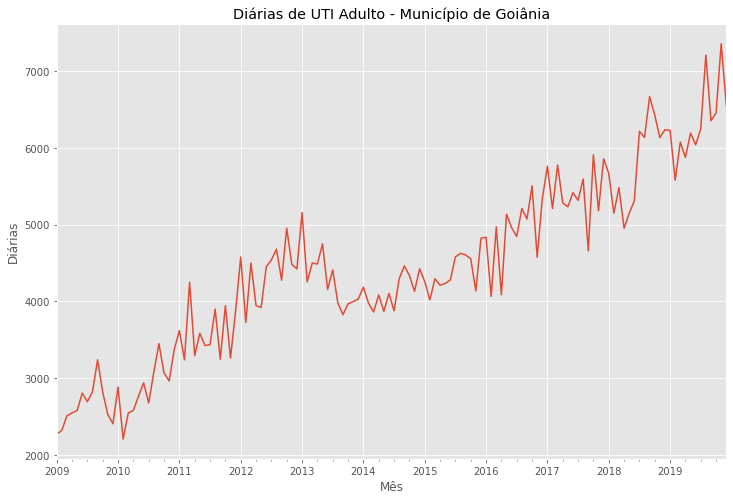

In [15]:
ax = aih_uti.plot(figsize=(12,8), legend=False, xlabel='Mês',
                  ylabel='Diárias', title = 'Diárias de UTI Adulto - Município de Goiânia')

### Verifica a relação entre os dados do SIHSUS e da evolução da população

In [16]:
ibge_aih_uti = pd.merge(aih_uti, ibge, on='MES')

In [17]:
#Verifica-se que há uma correlação forte entre os dados da população
#   e a quantidade de diárias de UTI
ibge_aih_uti.corr()

,DIARIAS_UTI,GOIANIA,GOIAS
DIARIAS_UTI,1.000000,0.895217,0.894645
GOIANIA,0.895217,1.000000,0.999925
GOIAS,0.894645,0.999925,1.000000


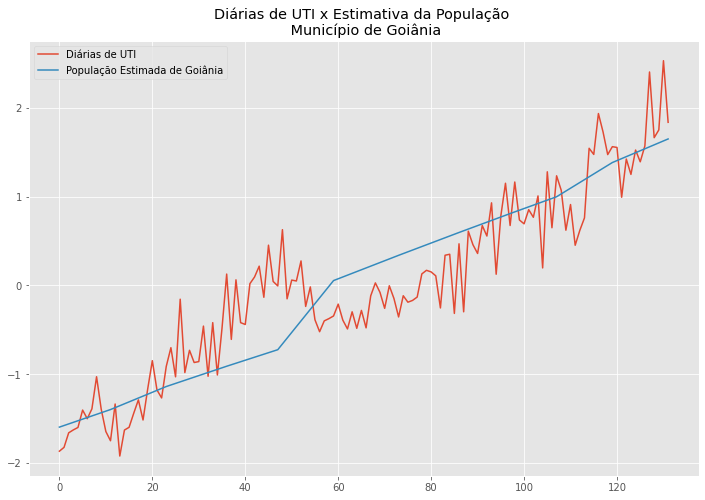

In [18]:
# Deixa os dados na mesma escala para verificação da relação visual
scaler = StandardScaler()
valores_escalados = scaler.fit_transform(ibge_aih_uti)
plt.figure(figsize=(12,8))
plt.plot(range(0, valores_escalados.shape[0]), valores_escalados[:,0], label='Diárias de UTI')
plt.plot(range(0, valores_escalados.shape[0]), valores_escalados[:,1], label='População Estimada de Goiânia')
plt.gca().set_title('Diárias de UTI x Estimativa da População \n Município de Goiânia')
plt.legend()

> Percebe que a população de Goiânia e de Goiás tem a mesma evolução, portanto será considerada apenas a população de Goiânia.

### Média Móvel Simples

In [19]:
#Cálcula uma média móvel simples com uma janela móvel de 12 meses
aih_uti['MMS-12'] = aih_uti['DIARIAS_UTI'].rolling(12).mean()

### Naive Forecasting

> https://otexts.com/fpp2/simple-methods.html

A previsão é setada na última observação.

In [20]:
aih_uti['NAIVE-FORECASTING'] = aih_uti['DIARIAS_UTI'].shift()

Text(0, 0.5, 'Diárias')

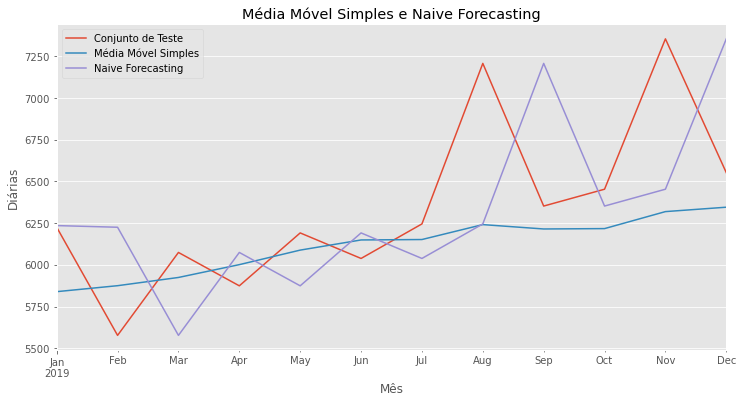

In [21]:
aih_uti[['DIARIAS_UTI','MMS-12','NAIVE-FORECASTING']][-12:].plot(title='Média Móvel Simples e Naive Forecasting',
                                                                figsize=(12,6))
plt.legend(['Conjunto de Teste', 'Média Móvel Simples', 'Naive Forecasting'])
plt.xlabel('Mês')
plt.ylabel('Diárias')

### Os valores da MMS e do Naive Forecasting serão usados como medidas comparativas dos modelos
> Calcula o erro quadrático médio  - MSE  (risco correspondente ao valor esperado do erro ou perda quadrática) e o erro quadrático médio - RMSE (raiz quadrada do segundo momento amostral das diferenças entre os valores previstos e os valores observados ou a média quadrática dessas diferenças) sobre o conjunto de teste (ano de 2019).

### Decomposição dos dados de diárias de UTI em tendência e sazonalidade

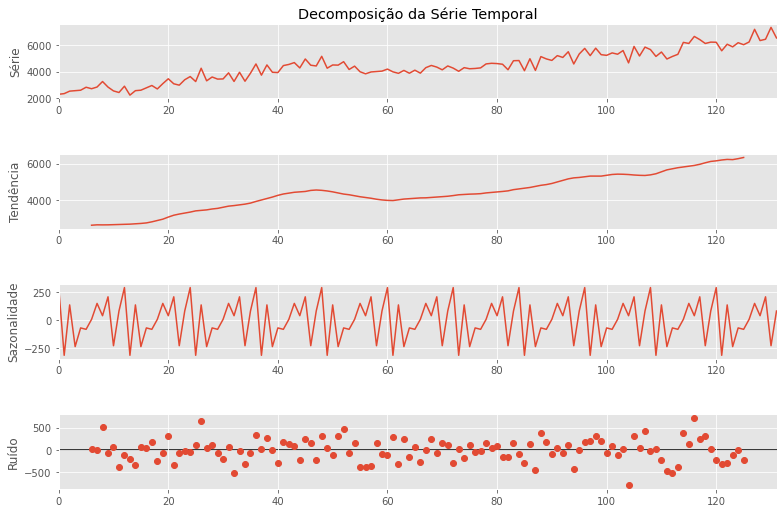

In [22]:
result = sm.tsa.seasonal_decompose(aih_uti['DIARIAS_UTI'].values, model='additive', period = 12)
figure = result.plot()
figure.set_size_inches(12,8)
figure.get_axes()[0].set_title('Decomposição da Série Temporal')
figure.get_axes()[0].set_ylabel('Série')
figure.get_axes()[1].set_ylabel('Tendência')
figure.get_axes()[2].set_ylabel('Sazonalidade')
figure.get_axes()[3].set_ylabel('Ruído')
plt.show()

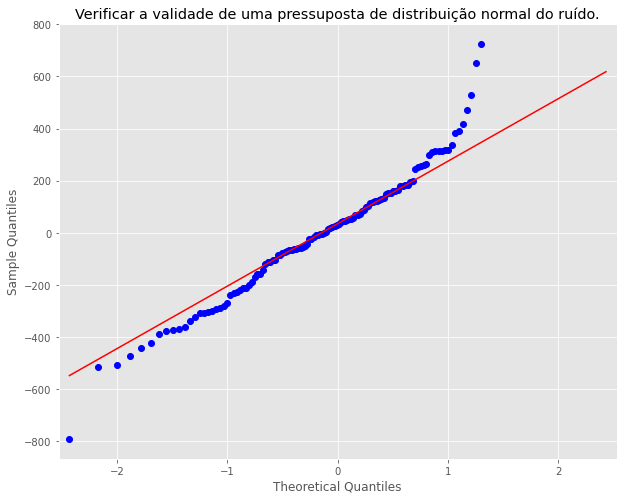

In [23]:
fig = qqplot(result.resid, line='q')
fig.set_size_inches(10,8)
fig.get_axes()[0].set_title('Verificar a validade de uma pressuposta de distribuição normal do ruído.')
plt.show()

### Tendências da série

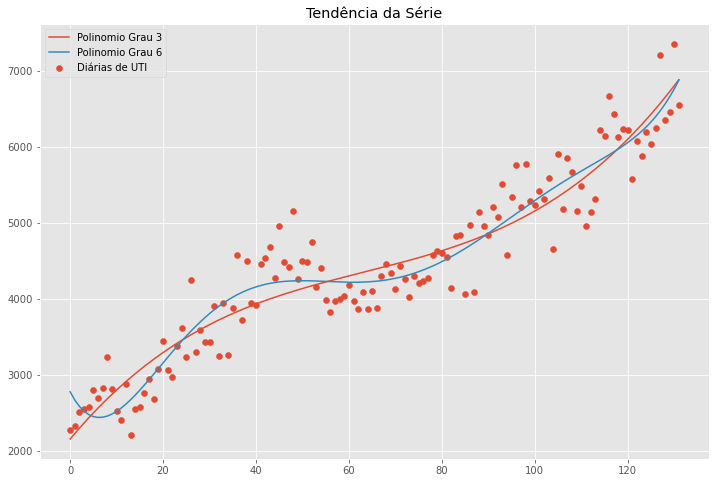

In [24]:
x = np.array(range(len(aih_uti.index)))
y = aih_uti['DIARIAS_UTI'].values
polynomial = np.polyfit(x, y, 3)
p1 = np.poly1d(polynomial)
polynomial = np.polyfit(x, y, 6)
p5 = np.poly1d(polynomial)
xx = np.linspace(x.min(), x.max(), len(y))
plt.rcParams['figure.figsize'] = [12,8]
plt.scatter(x,y,label="Diárias de UTI",marker='o') # Plota os dados
plt.plot(xx,p1(xx),label="Polinomio Grau 3")
plt.plot(xx,p5(xx),label="Polinomio Grau 6")
plt.title("Tendência da Série")
plt.legend()

### Verifica a estacionariedade da série

In [25]:
af_serie = adfuller(aih_uti['DIARIAS_UTI'].values, autolag='AIC')
af_serie_diff_1 = adfuller(aih_uti['DIARIAS_UTI'].diff().dropna(), autolag='AIC')
print(f'P-value: série = {round(af_serie[1],6)} - primeira diferença = {round(af_serie_diff_1[1],6)}')

P-value: série = 0.953982 - primeira diferença = 0.0


<AxesSubplot:title={'center':'Gráfico da Primeira Diferença da Série'}, xlabel='MES'>

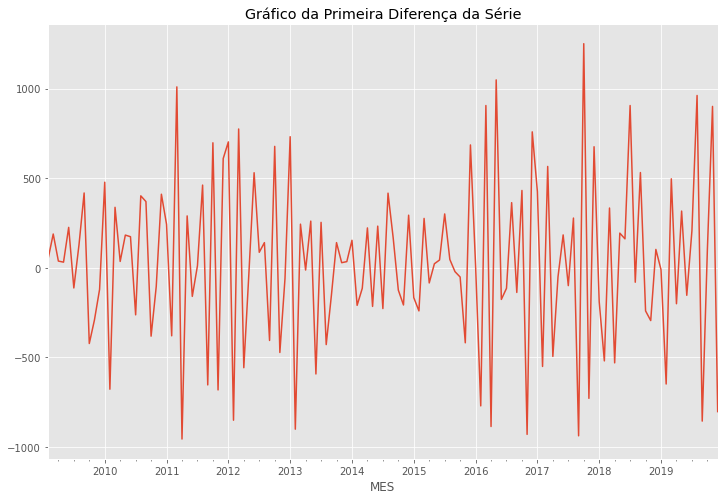

In [26]:
aih_uti['DIARIAS_UTI'].diff().dropna().plot(figsize=(12,8), title = 'Gráfico da Primeira Diferença da Série')

>  Pelo teste de Dickey-Fuller, há evidências fortes de que a série não seja estacionária. Todavia, para a primeira diferença, houve fortes evidências de estacionariedade da séries.

### Correlograma

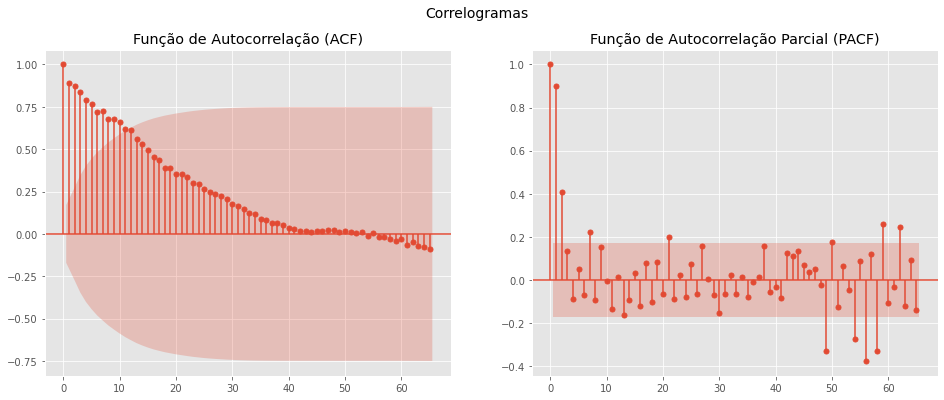

Lags = 65.0


In [27]:
lags = aih_uti.shape[0]/2 - 1 
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,6)
fig.suptitle('Correlogramas', fontsize=14)
plot_acf(aih_uti['DIARIAS_UTI'],title="Função de Autocorrelação (ACF)",lags=lags, ax=axs[0])
plot_pacf(aih_uti['DIARIAS_UTI'],title="Função de Autocorrelação Parcial (PACF)",lags=lags, ax=axs[1])
plt.show()
print(f'Lags = {lags}')

### Divisão entre treinamento e teste

In [28]:
treino = aih_uti[:-12]
teste = aih_uti[-12:]

treino_exog = sm.add_constant(ibge['GOIANIA'][:-12]) 
teste_exog = sm.add_constant(ibge['GOIANIA'][-12:])

### Modelo Holt

In [29]:
#Previsão Método Holt
holt = ExponentialSmoothing(treino['DIARIAS_UTI'],trend='add').fit().forecast(len(teste))
aih_uti['HOLT'] = holt

### Modelo Holt-Winters

In [30]:
#Previsão Método Holt-Winters
holt_winters = ExponentialSmoothing(treino['DIARIAS_UTI'],trend='add',seasonal='add',seasonal_periods=12)
holt_winters = holt_winters.fit().forecast(len(teste))
aih_uti['HOLT-WINTERS'] = holt_winters

Text(0, 0.5, 'Diárias')

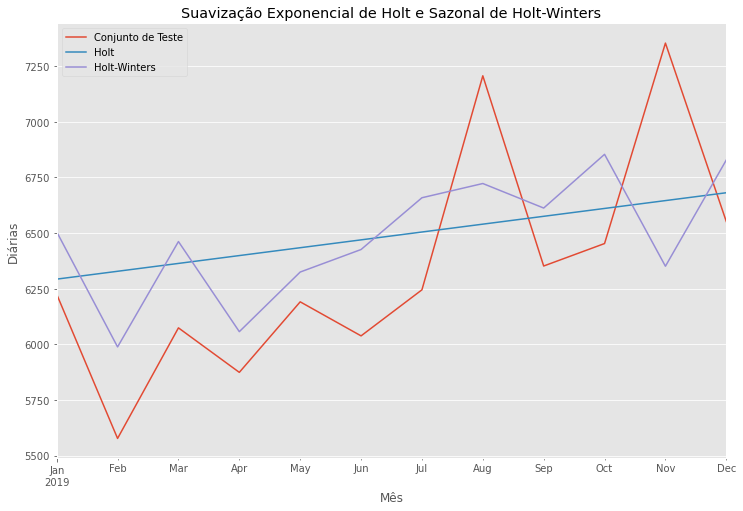

In [31]:
fig.set_size_inches(12,6)
aih_uti[['DIARIAS_UTI','HOLT','HOLT-WINTERS']][-12:].plot(title='Suavização Exponencial de Holt e Sazonal de Holt-Winters')
plt.legend(['Conjunto de Teste', 'Holt', 'Holt-Winters'])
plt.xlabel('Mês')
plt.ylabel('Diárias')

### Modelo ARIMA com Sazonalidade - SARIMA

In [32]:
stepwise_fit = auto_arima(y=treino['DIARIAS_UTI'],start_p=0, d=1, start_q=0,
                          max_p=10, max_d=2,
                          max_q=10, start_P=0,
                          D=1, start_Q=0, max_P=10,
                          max_Q=10, m = 12, seasonal=True,
                          error_action='warn',trace = True,
                          suppress_warnings=True, stepwise=True,
                          random=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1637.854, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1588.814, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1601.803, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1580.612, Time=0.26 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1567.792, Time=0.51 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1561.238, Time=1.36 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=1558.677, Time=2.23 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=1558.576, Time=1.67 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=1558.145, Time=2.22 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=4.57 sec
 ARIMA(1,1,0)(3,1,3)[12]             : AIC=i

In [33]:
resultado_sarima = SARIMAX(treino['DIARIAS_UTI'],order=(1,1,0),seasonal_order=(3,1,2,12)).fit()
resultado_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                             DIARIAS_UTI   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(3, 1, [1, 2], 12)   Log Likelihood                -772.072
Date:                                 Sun, 13 Dec 2020   AIC                           1558.145
Time:                                         20:10:22   BIC                           1576.855
Sample:                                     01-31-2009   HQIC                          1565.729
                                          - 12-31-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5311      0.087     -6.124      0.000      -0.701      -0.361
ar.S.L12       0.2105      0.267      0.789      0.430      -0.312       0.733
ar.S.L24      -0.3923      0.124     -3.158      0.002      -0.636      -0.149
ar.S.L36      -0.3455      0.162     -2.127      0.033      -0.664      -0.027
ma.S.L12      -1.2065      0.405     -2.977      0.003      -2.001      -0.412
ma.S.L24       0.5958      0.367      1.624      0.104      -0.123       1.315
sigma2      8.332e+04   1.57e+04      5.313      0.000    5.26e+04    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.95
Prob(Q):                              0.85   Prob(JB):                         0.23
Heteroskedasticity (H):               1.39   Skew:                             0.32
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Análise dos Resíduos

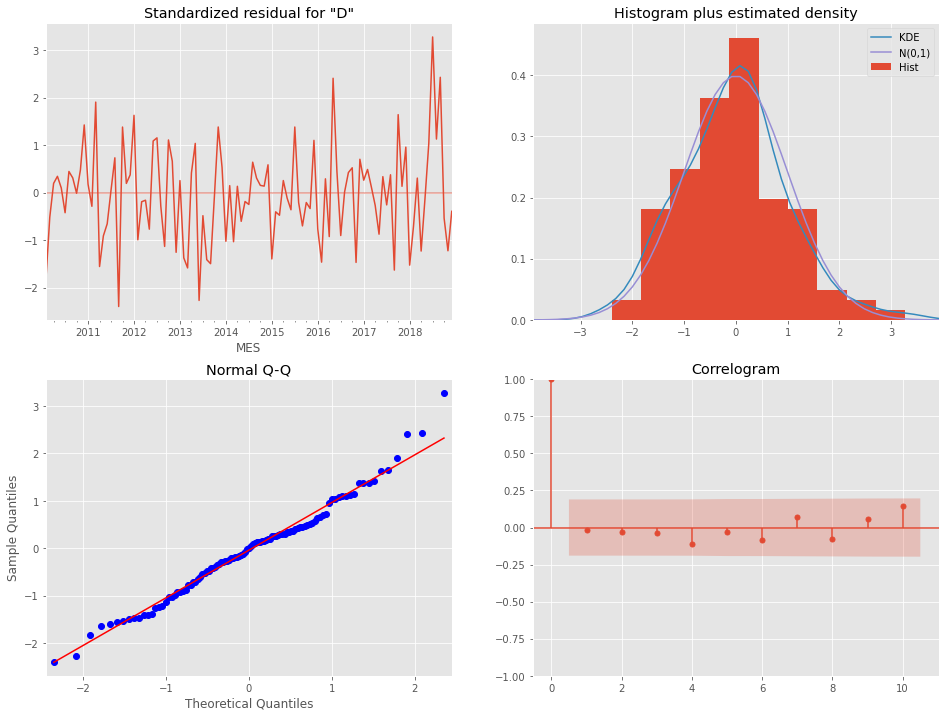

In [34]:
resultado_sarima.plot_diagnostics(figsize=(16, 12))
plt.show()

In [35]:
print(f'Teste de Shapiro-Wilk para normalidade (p-valor) para os resíduos = {round(shapiro(resultado_sarima.resid)[1], 6)}')

Teste de Shapiro-Wilk para normalidade (p-valor) para os resíduos = 0.0


In [36]:
inicio=len(treino)
fim=len(treino)+len(teste)-1
aih_uti['SARIMA(1,1,0)x(3,1,2)[12]'] = resultado_sarima.predict(start=inicio, end=fim, dynamic=False, typ='levels')

Text(0, 0.5, 'Diárias')

<Figure size 864x432 with 0 Axes>

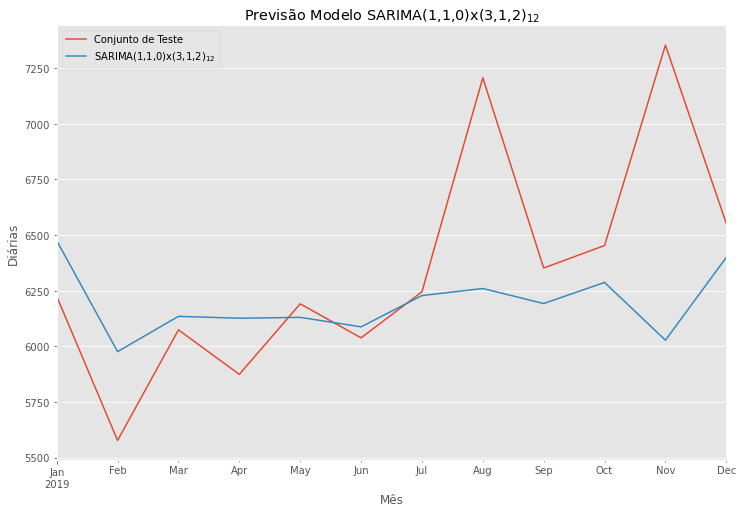

In [37]:
plt.figure(figsize=(12,6))
aih_uti[-12:][['DIARIAS_UTI','SARIMA(1,1,0)x(3,1,2)[12]']].plot(title='Previsão Modelo SARIMA(1,1,0)x(3,1,2)$_{12}$')
plt.legend(['Conjunto de Teste', 'SARIMA(1,1,0)x(3,1,2)$_{12}$'])
plt.xlabel('Mês')
plt.ylabel('Diárias')

### Modelo ARIMA com Sazonalidade - SARIMA - com inclusão de variável exógena

In [38]:
stepwise_fit = auto_arima(y=treino['DIARIAS_UTI'], exogenous = treino_exog, start_p=0, d=1, start_q=0,
                          max_p=10, max_d=2,
                          max_q=10, start_P=0,
                          D=1, start_Q=0, max_P=10,
                          max_Q=10, m = 12, seasonal=True,
                          error_action='warn',trace = True,
                          suppress_warnings=True, stepwise=True,
                          n_fits=50) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1641.401, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1591.528, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1604.042, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1586.173, Time=0.92 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1576.481, Time=2.48 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1577.217, Time=4.27 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=1576.572, Time=4.19 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1576.934, Time=2.31 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=1578.022, Time=4.58 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=1610.609, Time=1.12 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=1579.750, Time=1.57 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=1580.322, Time=2.58 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=1575.837, Time=2.97 sec
 ARIMA(0,1,1)(2,1,0)[12]

In [39]:
resultado_sarima_ex = SARIMAX(endog=treino['DIARIAS_UTI'], exog = treino_exog,order=(0,1,1),seasonal_order=(3,1,0,12)).fit()
resultado_sarima_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         DIARIAS_UTI   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -780.918
Date:                             Sun, 13 Dec 2020   AIC                           1575.837
Time:                                     20:11:16   BIC                           1594.547
Sample:                                 01-31-2009   HQIC                          1583.422
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1029   1.28e+04   8.04e-06      1.000   -2.51e+04    2.51e+04
GOIANIA        0.0022      0.010      0.213      0.832      -0.018       0.022
ma.L1         -0.5885      0.091     -6.439      0.000      -0.768      -0.409
ar.S.L12      -0.6558      0.107     -6.115      0.000      -0.866      -0.446
ar.S.L24      -0.5152      0.121     -4.275      0.000      -0.751      -0.279
ar.S.L36      -0.4311      0.110     -3.921      0.000      -0.647      -0.216
sigma2      1.164e+05   1.64e+04      7.081      0.000    8.41e+04    1.49e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.36   Prob(JB):                         0.55
Heteroskedasticity (H):               1.53   Skew:                             0.15
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Análise dos Resíduos

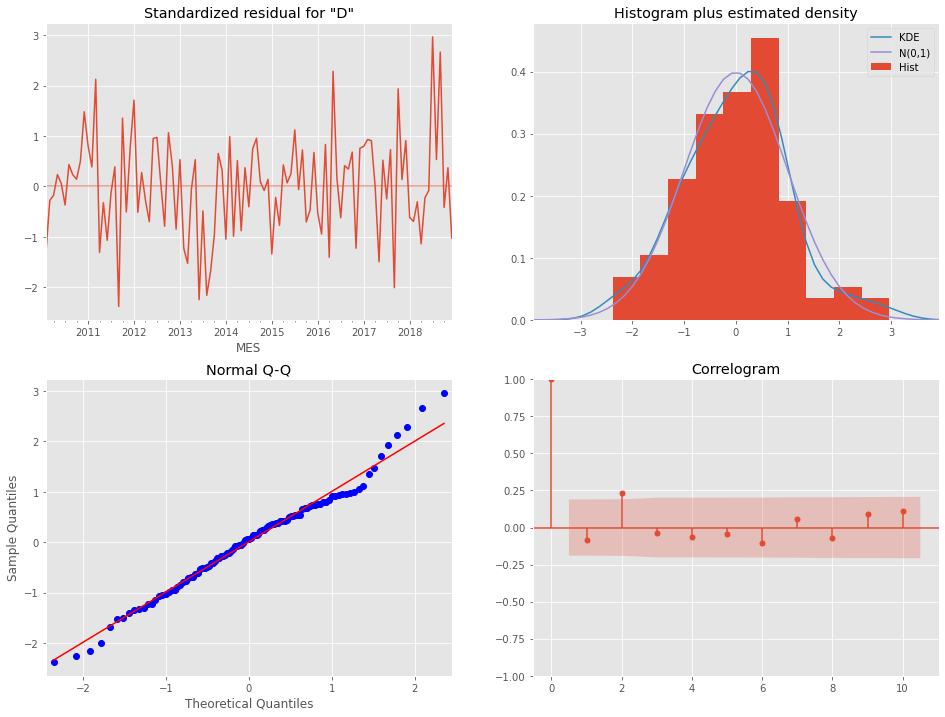

In [40]:
resultado_sarima_ex.plot_diagnostics(figsize=(16, 12))
plt.show()

In [41]:
print(f'Teste de Shapiro-Wilk para normalidade (p-valor) para os resíduos = {round(shapiro(resultado_sarima_ex.resid)[1], 6)}')

Teste de Shapiro-Wilk para normalidade (p-valor) para os resíduos = 0.466838


In [42]:
inicio=len(treino)
fim=len(treino)+len(teste)-1
aih_uti['SARIMA-ex(0,1,1)x(3,1,0)[12]'] = resultado_sarima_ex.predict(exog=teste_exog, start=inicio, end=fim, 
                                                                      dynamic=False, typ='levels')

Text(0, 0.5, 'Diárias')

<Figure size 864x432 with 0 Axes>

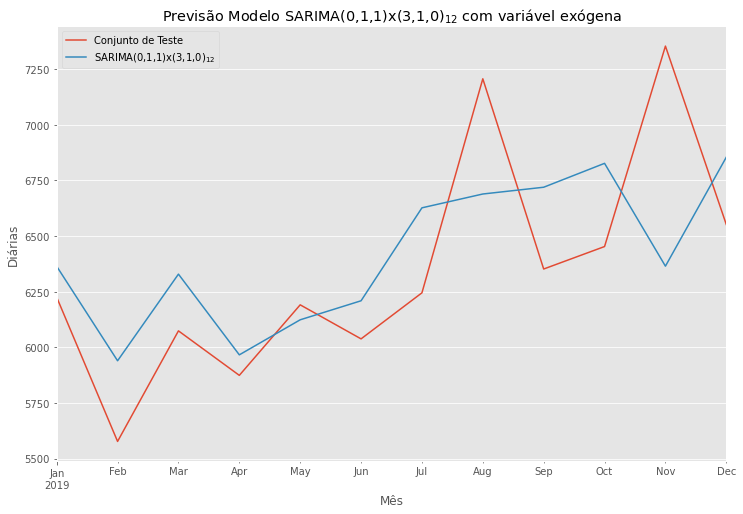

In [43]:
plt.figure(figsize=(12,6))
aih_uti[-12:][['DIARIAS_UTI','SARIMA-ex(0,1,1)x(3,1,0)[12]']]\
                .plot(title='Previsão Modelo SARIMA(0,1,1)x(3,1,0)$_{12}$ com variável exógena')
plt.legend(['Conjunto de Teste', 'SARIMA(0,1,1)x(3,1,0)$_{12}$'])
plt.xlabel('Mês')
plt.ylabel('Diárias')

### Long Short-Term Memory - LSTM

In [44]:
scaler = MinMaxScaler()
scaler.fit(treino[['DIARIAS_UTI']])

MinMaxScaler()

In [45]:
scaled_treino = scaler.transform(treino[['DIARIAS_UTI']])

In [46]:
generator = keras.preprocessing.sequence.TimeseriesGenerator(scaled_treino, scaled_treino, length=12, batch_size=1)

#### Funções LSTM


In [47]:
def modelo_lstm(dropout=False, learning_rate = 0.001):
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    modelo = keras.models.Sequential()
    modelo.add(keras.layers.LSTM(100, activation='relu', input_shape=(12, 1)))
    if dropout:
        modelo.add(keras.layers.Dropout (0.2))
    modelo.add(keras.layers.Dense(1))
    modelo.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    
    return modelo

In [48]:
def gera_predicoes(modelo):
    test_predictions = []

    first_eval_batch = scaled_treino[-12:]
    current_batch = first_eval_batch.reshape((1, 12, 1))

    for i in range(len(teste)):
    
        # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
        current_pred = modelo.predict(current_batch)[0]
    
        # predição
        test_predictions.append(current_pred) 
    
        # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
    return scaler.inverse_transform(test_predictions).reshape(1,12)

#### Modelo 01

In [49]:
LSTM_1 = modelo_lstm()
LSTM_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [50]:
LSTM_1.fit_generator(generator,epochs=100,verbose=0)

Instructions for updating:
Please use Model.fit, which supports generators.


In [51]:
aih_uti['LSTM-1'] = np.nan
aih_uti.iloc[-12:, aih_uti.columns.get_loc('LSTM-1')] = gera_predicoes(LSTM_1)

#### Modelo 02

In [52]:
LSTM_2 = modelo_lstm(dropout=True)
LSTM_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [53]:
LSTM_2.fit_generator(generator,epochs=100,verbose=0)

In [54]:
aih_uti['LSTM-2'] = np.nan
aih_uti.iloc[-12:, aih_uti.columns.get_loc('LSTM-2')] = gera_predicoes(LSTM_2)

#### Modelo 03

In [55]:
LSTM_3 = modelo_lstm(dropout=True)
LSTM_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [56]:
def scheduler(epoch, lr):
   if epoch < 20:
      return lr
   else:
      return np.clip(lr * tf.math.exp(-0.2), 0.00001, 0.001)

callbacklr = keras.callbacks.LearningRateScheduler(scheduler)

LSTM_3.fit_generator(generator,epochs=100, verbose = 0, callbacks=[callbacklr])

In [57]:
aih_uti['LSTM-3'] = np.nan
aih_uti.iloc[-12:, aih_uti.columns.get_loc('LSTM-3')] = gera_predicoes(LSTM_3)

#### Modelo 4

In [58]:
LSTM_4 = modelo_lstm()
LSTM_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [59]:
LSTM_4.fit_generator(generator,epochs=1000, verbose = 0)

In [60]:
aih_uti['LSTM-4'] = np.nan
aih_uti.iloc[-12:, aih_uti.columns.get_loc('LSTM-4')] = gera_predicoes(LSTM_4)

#### Modelo 5

In [61]:
LSTM_5 = modelo_lstm(learning_rate=0.0001)
LSTM_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [62]:
LSTM_5.fit_generator(generator,epochs=100, verbose = 0)

In [63]:
aih_uti['LSTM-5'] = np.nan
aih_uti.iloc[-12:, aih_uti.columns.get_loc('LSTM-5')] = gera_predicoes(LSTM_5)

Text(0, 0.5, 'Diárias')

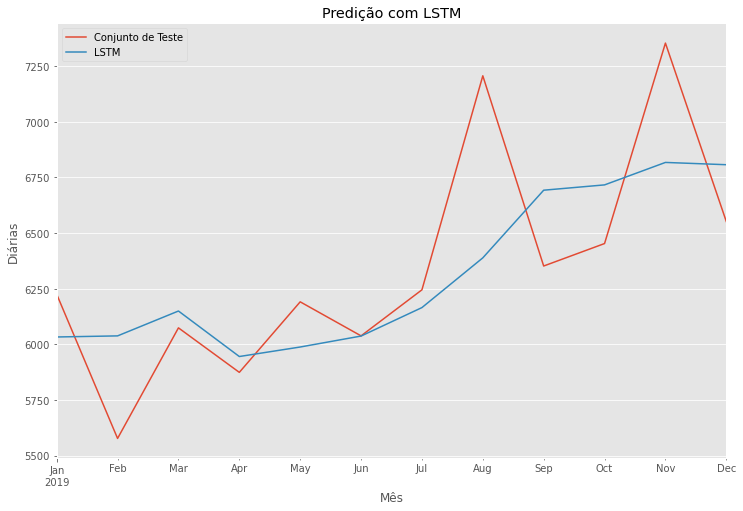

In [64]:
fig.set_size_inches(12,6)
aih_uti[['DIARIAS_UTI','LSTM-1']][-12:].plot(title='Predição com LSTM')
plt.legend(['Conjunto de Teste', 'LSTM'])
plt.xlabel('Mês')
plt.ylabel('Diárias')

### XGBoost

#### Prepara os dados para o algoritmo

In [65]:
X_train = treino['DIARIAS_UTI']
X_train = X_train[:-1].values.reshape(119,1)

In [66]:
y_train = treino['DIARIAS_UTI'].shift(-1)
y_train = y_train[:-1].values

In [67]:
# from https://machinelearningmastery.com/xgboost-for-time-series-forecasting
# from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        #print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
        # estimate prediction error        
        
    error = mean_absolute_error(test[:, -1], predictions)        
    return error, test[:, -1], predictions

In [68]:
# transform the time series data into supervised learning
for i in range(12):
    data = series_to_supervised(aih_uti['DIARIAS_UTI'].values.reshape(132,1), n_out=i+1)
    # evaluate
    mae, y, yhat = walk_forward_validation(data, 12)
    print(f'{i+1} : MAE: {mae}')

1 : MAE: 525.5830891927084
2 : MAE: 499.3213704427083
3 : MAE: 443.3862711588542
4 : MAE: 401.0168050130208
5 : MAE: 302.6715901692708
6 : MAE: 407.6719970703125
7 : MAE: 486.0097249348958
8 : MAE: 460.9636637369792
9 : MAE: 459.7838541666667
10 : MAE: 340.2710774739583
11 : MAE: 386.5120849609375
12 : MAE: 402.5362955729167


In [69]:
data = series_to_supervised(aih_uti['DIARIAS_UTI'].values.reshape(132,1), n_out=5)

In [70]:
trainX, trainy = data[:-12, :-1], data[:-12, -1]
testX, testy = data[-12:, :-1], data[-12:, -1]

In [71]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)
model.fit(trainX, trainy)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
current_vector = testX[0]
predict_val = []

for i in range(12):
    current_val = model.predict(np.asarray([current_vector]))
    predict_val.append(current_val)
    current_vector = np.append(current_vector, current_val)[-5:]    

In [73]:
aih_uti['XGB'] = np.nan
aih_uti.iloc[-12:, aih_uti.columns.get_loc('XGB')] = np.asarray([p[0] for p in predict_val])

Text(0, 0.5, 'Diárias')

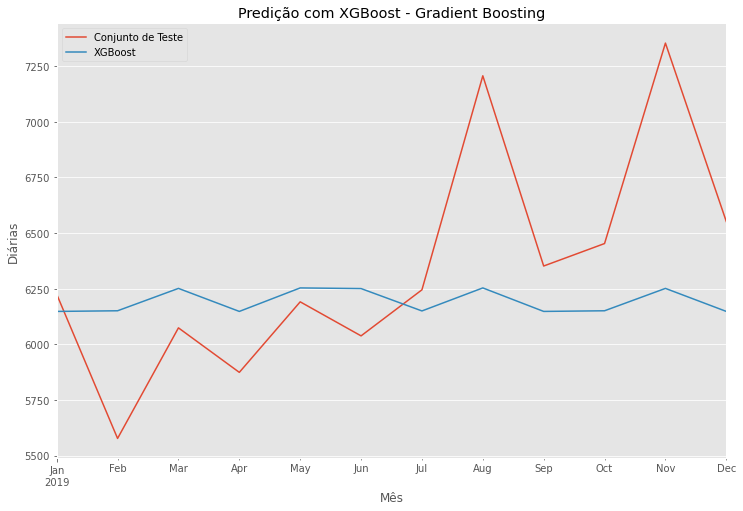

In [74]:
fig.set_size_inches(12,6)
aih_uti[['DIARIAS_UTI','XGB']][-12:].plot(title='Predição com XGBoost - Gradient Boosting')
plt.legend(['Conjunto de Teste', 'XGBoost'])
plt.xlabel('Mês')
plt.ylabel('Diárias')

### Avaliações

In [75]:
metodos = ['NAIVE-FORECASTING', 'HOLT', 'HOLT-WINTERS', 'SARIMA(1,1,0)x(3,1,2)[12]',
           'SARIMA-ex(0,1,1)x(3,1,0)[12]', 'LSTM-1', 'LSTM-2', 'LSTM-3', 'LSTM-4', 'LSTM-5',
           'XGB']

df_avaliacao = pd.DataFrame({'MSE': [mean_squared_error(aih_uti[-12:]['DIARIAS_UTI'], aih_uti[-12:]['MMS-12'])],
                                    'RMSE': [rmse(aih_uti[-12:]['DIARIAS_UTI'], aih_uti[-12:]['MMS-12'])]},
                                    index=['MMS-12'])

for metodo in metodos:
    df_avaliacao = df_avaliacao.append(pd.DataFrame({'MSE': [mean_squared_error(aih_uti[-12:]['DIARIAS_UTI'], aih_uti[-12:][metodo])],
                                                    'RMSE': [rmse(aih_uti[-12:]['DIARIAS_UTI'], aih_uti[-12:][metodo])]},
                                                     index=[metodo]))


<AxesSubplot:>

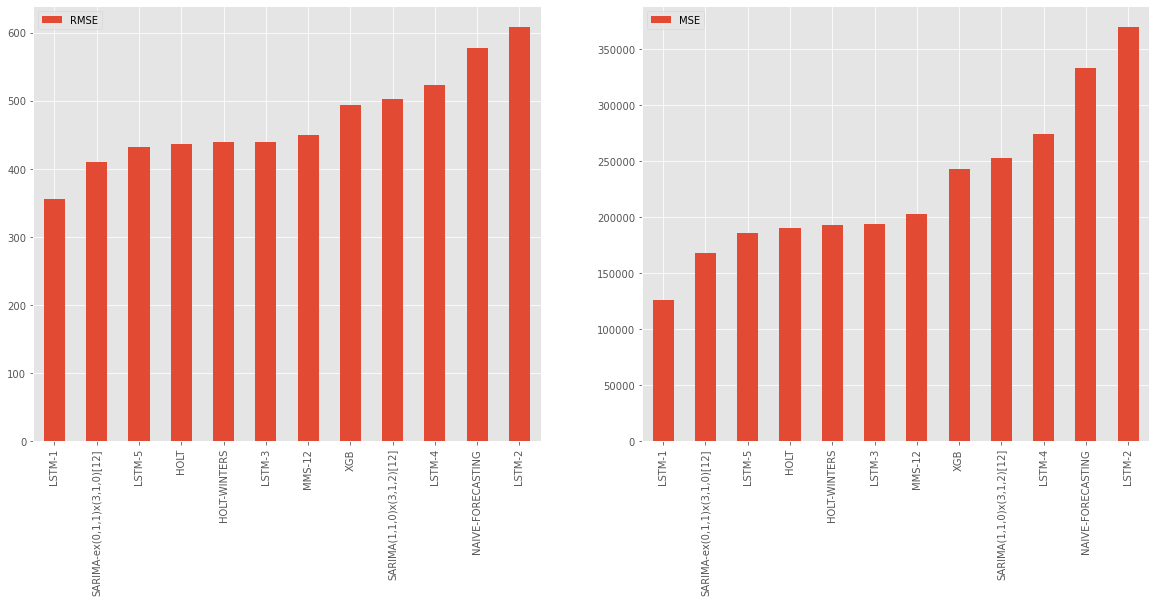

In [76]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,8)
df_avaliacao.sort_values('RMSE')[['RMSE']].plot(kind='bar', ax=axs[0])
df_avaliacao.sort_values('MSE')[['MSE']].plot(kind='bar', ax=axs[1])

In [77]:
avaliacao_previa_sarima1 = df_avaliacao.loc[['MMS-12', 'NAIVE-FORECASTING', 'HOLT', 'HOLT-WINTERS',
                  'SARIMA(1,1,0)x(3,1,2)[12]','XGB']][['RMSE']].sort_values(by='RMSE').round(2)
avaliacao_previa_sarima1.index = ['SEH', 'HW', 'MMS-12', 'XGB', 'SARIMA(1,1,0)x(3,1,2)[12]',
       'Naive Forecasting']
avaliacao_previa_sarima1.index.name= 'Modelo'
avaliacao_previa_sarima1

,RMSE
Modelo,
SEH,435.78
HW,439.44
MMS-12,450.04
XGB,493.37
"SARIMA(1,1,0)x(3,1,2)[12]",502.36
Naive Forecasting,577.02


In [78]:
avaliacao_previa_sarima2 = df_avaliacao.loc[['MMS-12', 'NAIVE-FORECASTING', 'HOLT', 'HOLT-WINTERS',
                  'SARIMA(1,1,0)x(3,1,2)[12]','XGB', 'SARIMA-ex(0,1,1)x(3,1,0)[12]']][['RMSE']].sort_values(by='RMSE').round(2)
avaliacao_previa_sarima2.index.name= 'Modelo'
avaliacao_previa_sarima2

,RMSE
Modelo,
"SARIMA-ex(0,1,1)x(3,1,0)[12]",410.01
HOLT,435.78
HOLT-WINTERS,439.44
MMS-12,450.04
XGB,493.37
"SARIMA(1,1,0)x(3,1,2)[12]",502.36
NAIVE-FORECASTING,577.02


In [79]:
avaliacao_lstm = df_avaliacao.loc[['LSTM-1','LSTM-2', 'LSTM-3', 'LSTM-4', 'LSTM-5']]
avaliacao_lstm.index = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
avaliacao_lstm.index.name= 'LSTM'
avaliacao_lstm = avaliacao_lstm.sort_values('RMSE')[['RMSE']]
avaliacao_lstm

,RMSE
LSTM,
Modelo 1,355.427605
Modelo 5,431.287381
Modelo 3,440.003188
Modelo 4,523.334248
Modelo 2,607.945507


### Conclusões

<AxesSubplot:title={'center':'Diárias de UTI, entre os anos 2016 e 2019, com a primeira diferença retirada (tendência).'}>

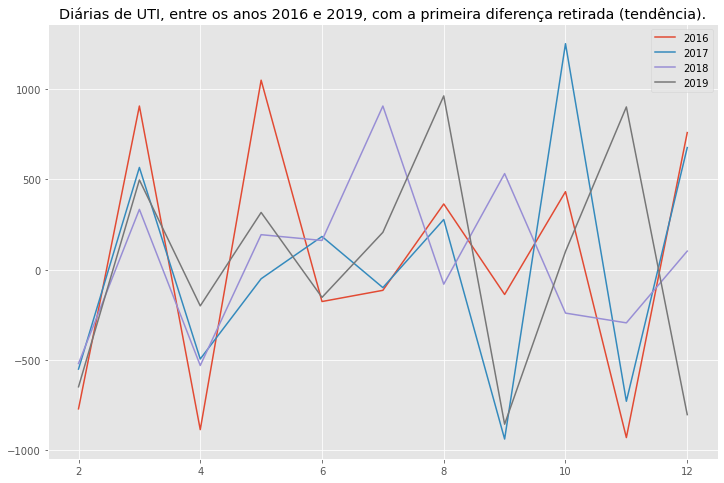

In [80]:
dados_2016 = aih_uti.loc['2016-01-01':'2016-12-31']['DIARIAS_UTI'].diff()
dados_2016.index = range(1,13)
dados_2017 = aih_uti.loc['2017-01-01':'2017-12-31']['DIARIAS_UTI'].diff()
dados_2017.index = range(1,13)
dados_2018 = aih_uti.loc['2018-01-01':'2018-12-31']['DIARIAS_UTI'].diff()
dados_2018.index = range(1,13)
dados_2019 = aih_uti.loc['2019-01-01':'2019-12-31']['DIARIAS_UTI'].diff()
dados_2019.index = range(1,13)
dados_2016_2019 = pd.concat([dados_2016,  dados_2017, dados_2018, dados_2019], axis=1)
dados_2016_2019.columns = ['2016', '2017', '2018', '2019']
dados_2016_2019.plot(title='Diárias de UTI, entre os anos 2016 e 2019, com a primeira diferença retirada (tendência).')

In [81]:
rmse_final = df_avaliacao.loc[['MMS-12', 'NAIVE-FORECASTING', 'HOLT', 'HOLT-WINTERS',
       'SARIMA(1,1,0)x(3,1,2)[12]', 'SARIMA-ex(0,1,1)x(3,1,0)[12]', 'LSTM-1', 'XGB']].copy()
rmse_final.index = ['MMS-12', 'Naive Forecasting', 'Holt', 'Holt Winters',
       'SARIMA(1,1,0)x(3,1,2)[12]', 'SARIMA-ex(0,1,1)x(3,1,0)[12]', 'LSTM', 'XGB']
rmse_final.index.name = 'Modelo'
rmse_final.sort_values('RMSE')[['RMSE']]

,RMSE
Modelo,
LSTM,355.427605
"SARIMA-ex(0,1,1)x(3,1,0)[12]",410.013385
Holt,435.784856
Holt Winters,439.442241
MMS-12,450.044552
XGB,493.371938
"SARIMA(1,1,0)x(3,1,2)[12]",502.364932
Naive Forecasting,577.020725
